import modules

In [1]:
import torch as t
import numpy as np
from experiment_helper import chop_and_shuffle_data, generate_sequence, dist, dim_specific_MSE, dim_specific_dist, distV2
from diffusion_gumbel import diffuse_STE
from reaction_diff import rho_STE
from tqdm import tqdm
import matplotlib.pyplot as plt
import os 
from os import path, getcwd
import time
import imageio
import random

c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


set device

In [2]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


generate data

In [4]:
grid = t.zeros((2, 64, 64), device=device)
grid[:] = 25
grid[0, 29:35] = 40

gamma = 0.005
k1 = k1_bar = 0.98
k2 = k2_bar = 0.1
k3 = k3_bar = 0.2

N = 50
num_steps = 30_000
DA = 0.1
DB = 0.4

sequence = generate_sequence(
    grid,
    num_steps,
    N,
    use_diffusion=True,
    DA=DA,
    DB=DB,
    use_reaction=True,
    gamma=gamma,
    k1=k1,
    k1_bar=k1_bar,
    k2=k2,
    k2_bar=k2_bar,
    k3=k3,
    k3_bar=k3_bar,
    create_vis=True,
    save_steps=True,
    create_seq=False
)


100%|██████████| 30000/30000 [05:33<00:00, 90.04it/s] 


In [11]:
import imageio
images = []
im_counter = 0
while im_counter < 30_000:
    images.append(imageio.imread(path.join(os.getcwd(), "vis", "test_k1_0.1", f"{im_counter}.png")))
    im_counter +=  100
imageio.mimsave(path.join(os.getcwd(), "gif", 'test_k1_0.1.gif'), images)

C:\Users\jsche\AppData\Local\Temp\ipykernel_3160\455026676.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(path.join(os.getcwd(), "vis", "test_k1_0.1", f"{im_counter}.png")))


create Torch dataset from the data

In [4]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, data_dir, device, grid_dim=None):
        self.data_dir = data_dir
        self.grid_dim = grid_dim
        self.device = device

    def __len__(self):
        batch_dirs = os.listdir(self.data_dir)
        return (len(batch_dirs)-1)*100 + len(os.listdir(path.join(self.data_dir, f"batch_{len(batch_dirs)-1}"))) - 1

    def __getitem__(self, idx):
        if type(idx) == int:
            batch_X = idx // 100
            entry_X = idx % 100
            
            batch_Y = (idx+1) // 100
            entry_Y = (idx+1) % 100
            
            #print(f"X: batch_{batch_X}/{entry_X}\nY: batch_{batch_Y}/{entry_Y}")
            return (
                    t.load(path.join(self.data_dir, f"batch_{batch_X}", f"{entry_X}.pt"), map_location=self.device), 
                    t.load(path.join(self.data_dir, f"batch_{batch_Y}", f"{entry_Y}.pt"), map_location=self.device)
            )
        elif type(idx) == list:
            dataset = t.zeros((len(idx), 2, 2, self.grid_dim, self.grid_dim), device=device)
            for i, d_idx in enumerate(idx):
                batch_X = d_idx // 100
                entry_X = d_idx % 100
                
                batch_Y = (d_idx+1) // 100
                entry_Y = (d_idx+1) % 100
                
                dataset[i, 0] = t.load(path.join(self.data_dir, f"batch_{batch_X}", f"{entry_X}.pt"), map_location=self.device)
                dataset[i, 1] = t.load(path.join(self.data_dir, f"batch_{batch_Y}", f"{entry_Y}.pt"), map_location=self.device)
            return dataset

In [5]:
data_dir = os.path.join(getcwd(), "data", "1674159018.515128")
train_data = CustomDataset(data_dir, device, grid_dim=64)
len(train_data)

30000

define a RandomSampler for the dataset

In [6]:
from torch.utils.data import RandomSampler
train_sampler = RandomSampler(train_data)

wrap the Randomsampler with a BatchSampler

In [7]:
from torch.utils.data.sampler import BatchSampler
batch_size = 1000
batch_sampler = BatchSampler(train_sampler, batch_size=batch_size, drop_last=True)

visualize distance and gradients for k1 

In [8]:
# We want to use a random batch of training data for the visualization
data_batch = train_data[list(batch_sampler)[0]]
X = data_batch[:,0]
Y_obs = data_batch[:,1]

displaying sample #3151 from the batch


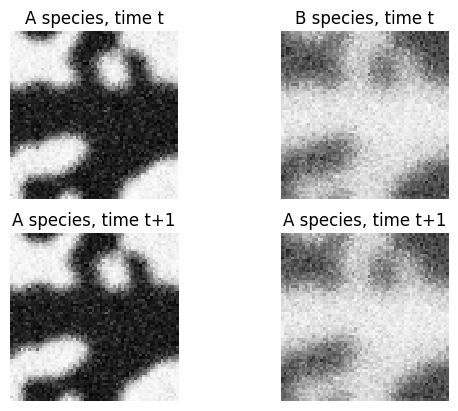

In [22]:
idx = random.randint(0, len(data_batch)-1)
print(f"displaying sample #{idx} from the batch")

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(X[idx,0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[0,0].set_title("A species, time t")
axs[0,0].axis("off")
axs[0,1].imshow(X[idx,1].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[0,1].set_title("B species, time t")
axs[0,1].axis("off")
axs[1,0].imshow(Y_obs[idx,0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1,0].set_title("A species, time t+1")
axs[1,0].axis("off")
axs[1,1].imshow(Y_obs[idx,1].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1,1].set_title("A species, time t+1")
axs[1,1].axis("off")

plt.show()


In [28]:
# we use the original DA and DB values
DA = t.tensor(0.1, device=device)
DB = t.tensor(0.4, device=device)
# we use the original rate coefficients for the other reaction channels
k1_bar = t.tensor(0.98, device=device)
k2 = t.tensor(0.1)
k2_bar = t.tensor(0.1, device=device)
k3 = t.tensor(0.2, device=device)
k3_bar = t.tensor(0.2, device=device)
# reaction time constant
gamma = t.tensor(0.005, device=device)
# occupation max. per cell
N = 50

# rate coefficient range
k1_vals = t.linspace(0.0001, 0.9999, 100)

distances = []
gradients = []
for k1 in tqdm(k1_vals):
    k1.requires_grad_()
    # 1. run the diffusion step on each sample
    diffused_samples = diffuse_STE(X, N, DA, DB)
    # 2. run the reaction step on each sample
    Y_sim = rho_STE(diffused_samples, N, gamma, k1, k1_bar, k2, k2_bar, k3, k3_bar)
    # use the sum of dim-specific distances
    dist_val = distV2(X, Y_sim, Y_obs)
    distances.append(dist_val.detach().cpu().numpy())
    # get the gradient w.r.t. the distance
    grad_k1 = t.autograd.grad(dist_val, k1)[0]
    gradients.append(grad_k1.detach().cpu().numpy())

100%|██████████| 100/100 [03:47<00:00,  2.28s/it]


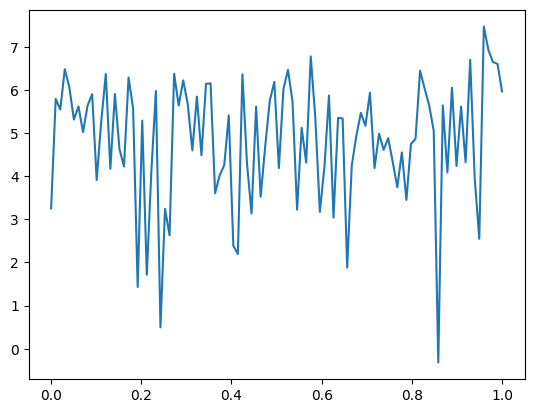

In [31]:
plt.plot(k1_vals.cpu(), np.log(distances))

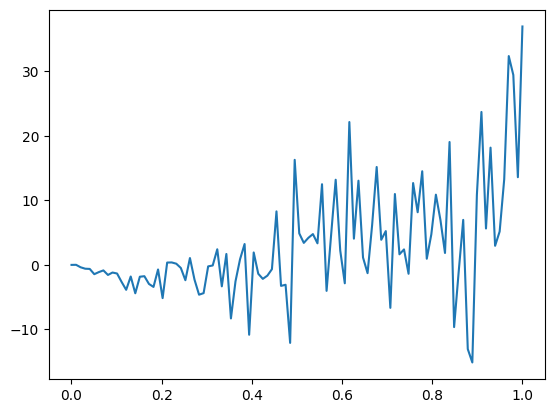

In [30]:
plt.plot(k1_vals.cpu(), gradients)

In [10]:
# we use the original DA and DB values
DB = t.tensor(0.4, device=device)
# we use the original rate coefficients for the other reaction channels
k1 = t.tensor(0.98, device=device)
k1_bar = t.tensor(0.98, device=device)
k2 = t.tensor(0.1)
k2_bar = t.tensor(0.1, device=device)
k3 = t.tensor(0.2, device=device)
k3_bar = t.tensor(0.2, device=device)
# reaction time constant
gamma = t.tensor(0.005, device=device)
# occupation max. per cell
N = 50

# DA range
DA_vals = t.linspace(0.0001, 0.9999, 100, device=device)

distances = []
gradients = []
for DA in tqdm(DA_vals):
    DA.requires_grad_()
    # 1. run the diffusion step on each sample
    diffused_samples = diffuse_STE(X, N, DA, DB)
    # 2. run the reaction step on each sample
    Y_sim = rho_STE(diffused_samples, N, gamma, k1, k1_bar, k2, k2_bar, k3, k3_bar)
    # use the sum of dim-specific distances
    dist_val = distV2(X, Y_sim, Y_obs)
    distances.append(dist_val.detach().cpu().numpy())
    # get the gradient w.r.t. the distance
    grad_DA = t.autograd.grad(dist_val, DA)[0]
    gradients.append(grad_DA.detach().cpu().numpy())

100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


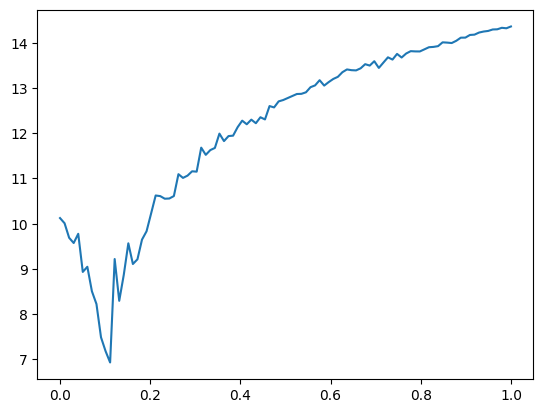

In [11]:
plt.plot(DA_vals.cpu(), np.log(distances))